In [1]:
WORKSPACE_PATH = 'workspace'
SCRIPTS_PATH = 'scripts'
APIMODEL_PATH = 'models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'


In [2]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}


Successfully created the TFRecord file: workspace/annotations/train.record
Successfully created the TFRecord file: workspace/annotations/test.record


In [3]:
!git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [4]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'


In [5]:
!mkdir {'workspace/models/'+CUSTOM_MODEL_NAME}
#copy for windows / cp for mac
!copy {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}


The syntax of the command is incorrect.


The syntax of the command is incorrect.


In [6]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

import cv2
import numpy as np

import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder



In [7]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)


In [8]:
config


{'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)


In [10]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH + \
    '/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [
    ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + \
    '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [
    ANNOTATION_PATH + '/test.record']


In [11]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:
    f.write(config_text)


In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=10000""".format(
    APIMODEL_PATH, MODEL_PATH, CUSTOM_MODEL_NAME, MODEL_PATH, CUSTOM_MODEL_NAME))


python models/research/object_detection/model_main_tf2.py --model_dir=workspace/models/my_ssd_mobnet --pipeline_config_path=workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=10000


In [14]:
#!python models/research/object_detection/model_main_tf2.py --model_dir=workspace/models/my_ssd_mobnet --pipeline_config_path=workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=10000

In [15]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(
    model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-21')).expect_partial()


@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


In [16]:
category_index = label_map_util.create_category_index_from_labelmap(
    ANNOTATION_PATH+'/label_map.pbtxt')


In [17]:
from PIL import Image
import matplotlib.pyplot as plt
from six import BytesIO
from six.moves.urllib.request import urlopen
%matplotlib inline


In [18]:
def load_image_into_numpy_array(path):
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    # image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(path)
    image = image.convert('RGB')
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


In [23]:
def detect_in_image(path):
    image_np = load_image_into_numpy_array(path)[0]

    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(
        np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=10,
        min_score_thresh=0.00,
        agnostic_mode=False)

    plt.figure(figsize=(24, 32))
    plt.imshow(image_np_with_detections)
    plt.imsave("test.png", image_np_with_detections)
    plt.show()

    print(num_detections)

    # cv2.imshow('object detection',  cv2.resize(
    #     image_np_with_detections, (800, 600)))


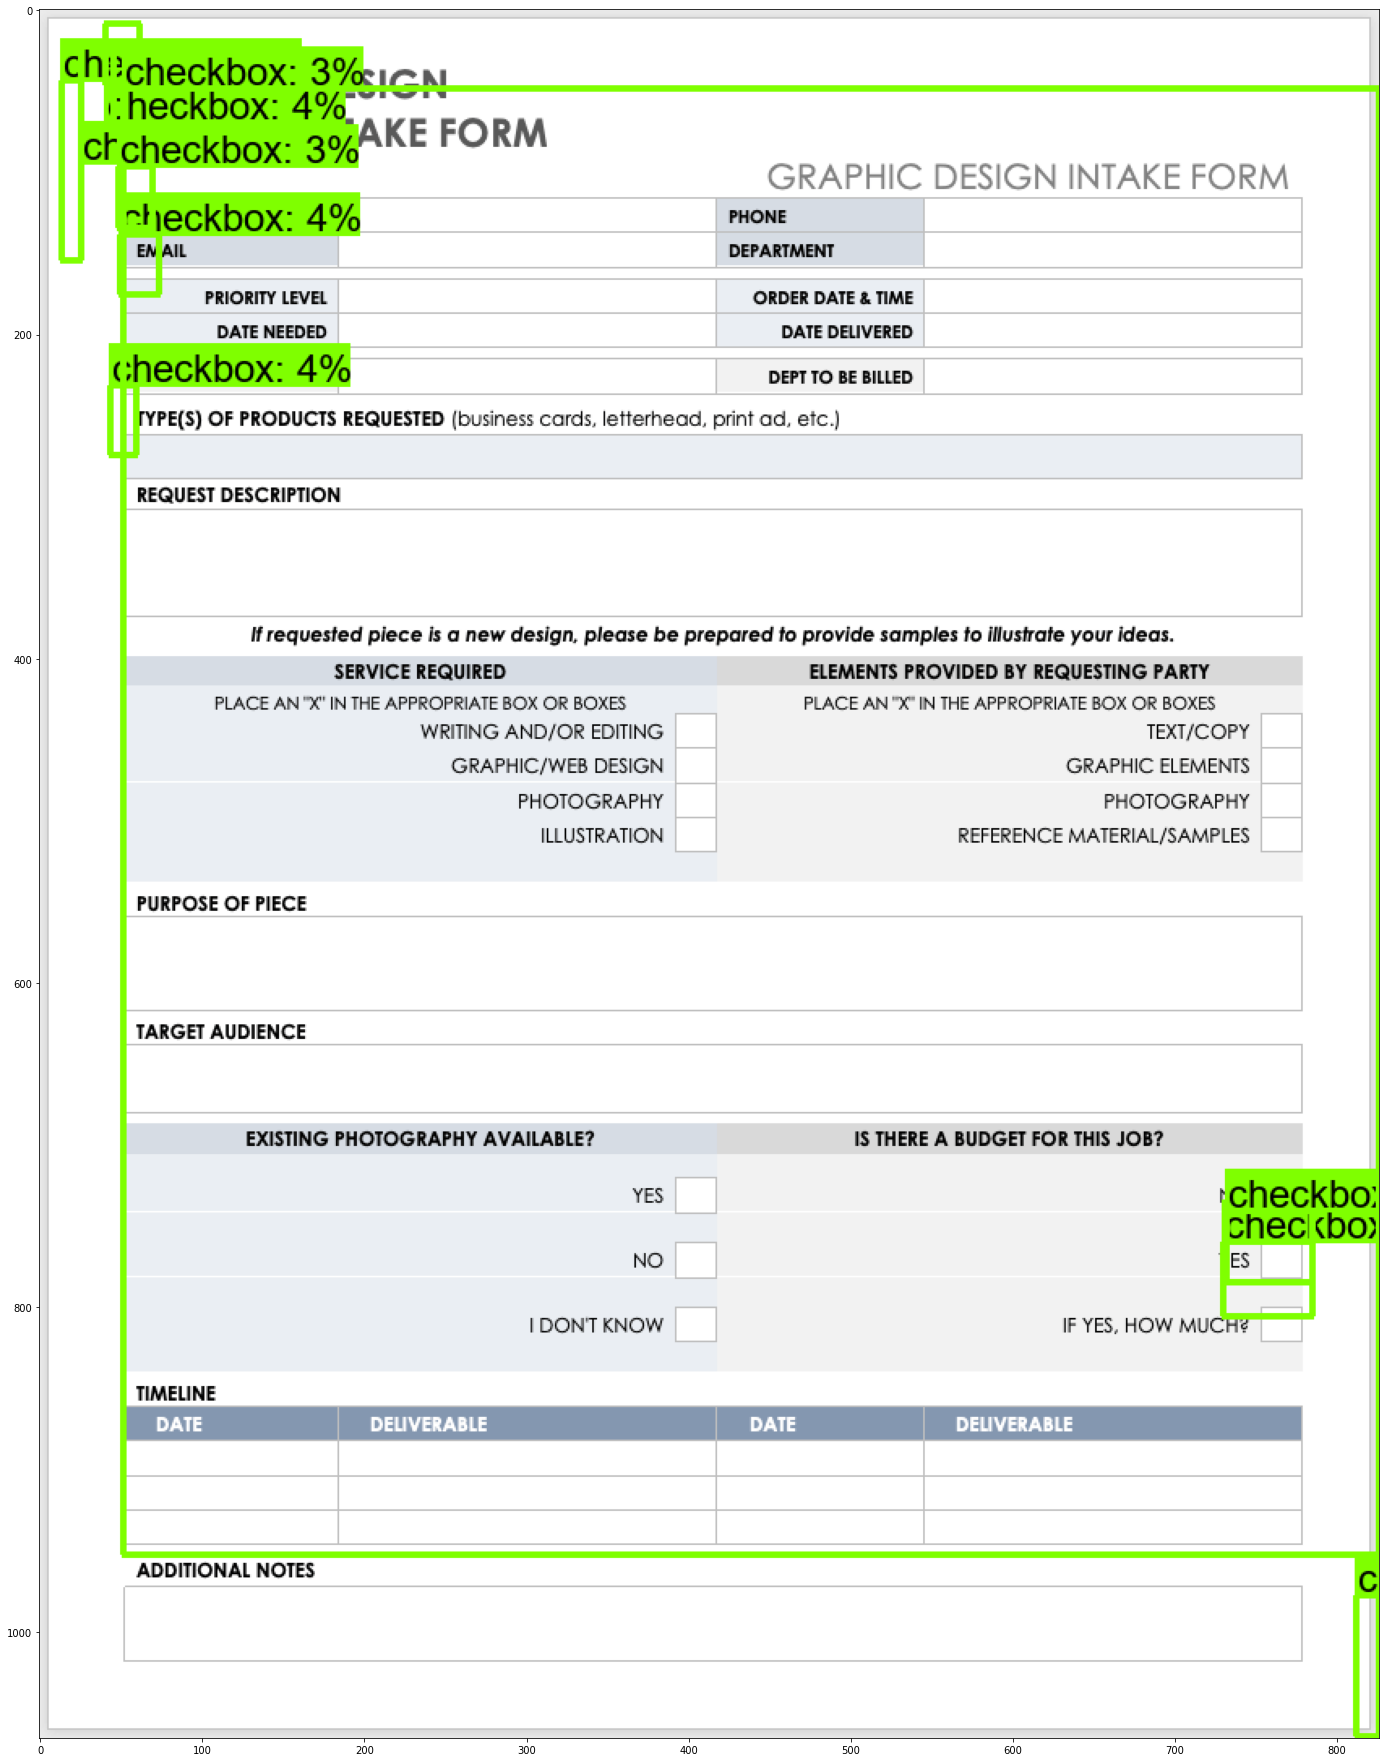

100


In [24]:
detect_in_image("test6.jpeg", )
